# BOARD GAME REVIEWS SENTIMENT ANALYSIS PROJECT

This is an example project for sentiment analysis.
It is based on a kaggle dataset scraped from Board Game Geek (like IMDB but for board games).The dataset contains both games metadata and more than 19M users rating and reviews.

By using the users ratings alongside their comments, we can compare the results to the actual ratings and see whether the sentiment matches the score.
As a best practice, we will use an NPS scoring method to label our reviews, meaning:
0-6: Negative
7-8: Neutral
9-10: Postive

The project includes:
1. Import and cleaning of data
2. EDA (exploratory data analysis)
3. Setiment analysis
4. Bonus section - wordcloud

## Project set up

### Dataset explanation

from this table we only take 3 relevant columns:

id - game id
comment - text comment of the game
rating - the user's rating of the game (1-10).

The data is based on ratings taken from the Board Game Geek [website](https://boardgamegeek.com)

### Imports

In [1]:
# the fasttext package will allow us to detect the language of the comment
!pip install fasttext-langdetect

  Preparing metadata (setup.py) ... - \ | done
  Created wheel for fasttext-langdetect: filename=fasttext_langdetect-1.0.5-py3-none-any.whl size=7523 sha256=94efa9a2926fbf0f3d3f5bd7d4e6ef63d05cc42c4352e5d0017020a4b391a9f1
  Stored in directory: /root/.cache/pip/wheels/e6/5b/5d/47e2fd5c2ff1028722739ce35f365e8f6eeb89ec97aa63e621
Successfully built fasttext-langdetect


In [2]:
import random
import numpy as np 
import pandas as pd 
import os
from basic_utils import INPUT_FOLDER, dfCleaner
import seaborn as sns
from matplotlib import pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from ftlangdetect import detect

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Constants and functions

In [3]:
# constnats
DATA_PATH = os.path.join(INPUT_FOLDER, "boardgamegeek-reviews")
RATING_COLS = ['comment','rating','ID']
sid = SentimentIntensityAnalyzer()
random.seed(4321)
df_cleaner = dfCleaner()
RANDOM_SAMPLE_SIZE = 0.05
SAMPLE_SIZE = 10000
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

The following function describes the pipeline for cleaning the text before using it in the sentiment analyzer.
Since the sentiment analysis uses both capitalization and punctuation as features, the only change we make is to remove words that symbolizes names, since they might include game names that will be marked as sentiments.
For example:

In [4]:
# here the negative score is very high, althoguh it shouldnt be
sid.polarity_scores("I like Cry Havoc")

{'neg': 0.737, 'neu': 0.0, 'pos': 0.263, 'compound': -0.6705}

In [5]:
# hin comparison with
sid.polarity_scores("I like")

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3612}

In [6]:
def word_cleaning_pipeline(sentence):
    new_sentence = []
    for word, tag in nltk.pos_tag(nltk.word_tokenize(sentence)):
        if tag != "NNP":
            new_sentence.append(word)
    fixed_text = ' '.join(new_sentence)
    return fixed_text

### Data import

In [7]:
# for the sake of speed, we read a random 5% of the rows, which are ~1M rows
reviews = pd.read_csv(os.path.join(DATA_PATH, "bgg-19m-reviews.csv"), 
                     usecols=RATING_COLS, skiprows=lambda x: x > 0 and random.random() >=RANDOM_SAMPLE_SIZE)
df_cleaner.column_name_cleaner(df_to_clean=reviews)
reviews.sample(10)

,rating,comment,id
678665,5.0,NaN,11634
888923,3.0,NaN,8497
424233,6.0,NaN,172081
370092,6.5,NaN,48726
245023,8.0,NaN,155426
521808,8.0,NaN,21050
448729,7.0,NaN,24068
794523,8.0,NaN,75223
660864,7.0,NaN,6607
346235,5.0,NaN,2243


## EDA

we can see that most of the comments column is empty.
which makes sense since most reviews tend to only leave a rating without
a comment

In [8]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948305 entries, 0 to 948304
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   rating   948305 non-null  float64
 1   comment  168340 non-null  object 
 2   id       948305 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 21.7+ MB


In [9]:
# add a T/F column whether the rating is accompanied by a comment
reviews['has_comment'] = np.where(reviews['comment'].isna(), False, True)

we can see here similar distribution between ratings with and without comments
suggesting that adding a comment doesn't provide us with information of the expected rating of that game. 
Or in simple words - those who comment do so for good and bad games.

[Text(0.5, 0, 'Rating with comment'),
 Text(0, 0.5, 'Rating'),
 Text(0.5, 1.0, 'Ratings distribution w/o comments')]

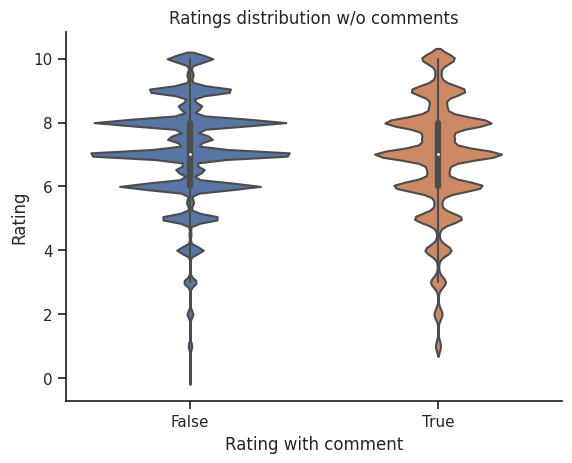

In [10]:
chart = sns.violinplot(data=reviews, x='has_comment', y='rating')
chart.set(xlabel="Rating with comment",
       ylabel='Rating',
       title='Ratings distribution w/o comments')

In [11]:
# filter missing comments
comment_reviews = reviews.dropna()

#To simplify our analysis, we will group together ratings into categories, 
based on the common best practice of NPS, meaning:
1-6 = Negative, 7-8 = Neutral, 9-10 = Positive

In [12]:
comment_reviews["NPS"] = pd.cut(comment_reviews['rating'], [0,6,8,10], right=False, labels=["negative", "neutral", "positive"])
comment_reviews.sample(10)

/tmp/ipykernel_21/2163595862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_reviews["NPS"] = pd.cut(comment_reviews['rating'], [0,6,8,10], right=False, labels=["negative", "neutral", "positive"])


,rating,comment,id,has_comment,NPS
783966,5.0,Managed to get my parents and bro to play a fe...,1549,True,negative
559245,1.0,Board Game - Family - Roll/spinn & move Played...,2136,True,negative
810976,5.0,"boring, even for kids not too excited.",5824,True,negative
733987,9.0,Kickstarter 1st Edition,272533,True,positive
634540,8.0,Opened and discs labeled. Never played,57390,True,positive
74323,7.5,Light euro-style game with beautiful artwork. ...,70919,True,neutral
566225,7.5,Gioco bastardissimo in cui bisogna costituire ...,132372,True,neutral
725482,6.0,"I liked the premise and the core of the game, ...",179460,True,neutral
222,10.0,weight: 2.89,170216,True,NaN
817010,7.5,There's a lot to like in this one: The supress...,41429,True,neutral


out of ~170k comments, about 10% are shorter than 20 characters.
however, there is no clear indication that shorter comments are worthless
some are complimentary to the rating, for example "with expansion"
but some are relevant - "Wonderful!", "it's funny!"

In [13]:
comment_reviews['comment_length'] = comment_reviews['comment'].str.len()
comment_reviews[comment_reviews['comment_length']<=20]

/tmp/ipykernel_21/3210239252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_reviews['comment_length'] = comment_reviews['comment'].str.len()


,rating,comment,id,has_comment,NPS,comment_length
21,10.0,With expansion.,36218,True,NaN,15
45,10.0,P,173346,True,NaN,1
51,10.0,Wonderful!,31260,True,NaN,10
78,10.0,1 no E online 6-9-07,14996,True,NaN,20
175,10.0,Fusm,150376,True,NaN,4
...,...,...,...,...,...,...
948169,7.1,S&T25,11498,True,neutral,5
948227,5.0,2 - 6 players,33789,True,negative,13
948228,4.0,It's Monopoly.,33789,True,negative,16
948235,5.0,Oh its mad alright.,9250,True,negative,19


By looking at the comment length at various resolutions, we can see that:
1. long commments are common for each of the rating category, meaning that
a longer comment doesnt necessary mean that the game is either good or bad
2. comments in general have similar lengths across the rating categories, 
with a median value of ~110 characters

[Text(0.5, 0, 'NPS category'),
 Text(0, 0.5, 'Comment Length'),
 Text(0.5, 1.0, 'Comment length distribution by category (short comment)')]

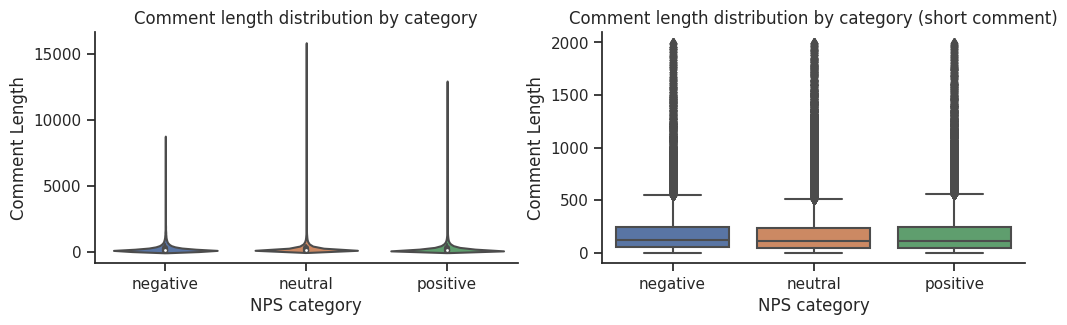

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
short_reviews = comment_reviews[comment_reviews['comment_length']<2000]
chart_1 = sns.violinplot(data=comment_reviews, x='NPS', y='comment_length', ax=axs[0])
chart_1.set(xlabel="NPS category",
       ylabel='Comment Length',
       title='Comment length distribution by category')
chart_2 = sns.boxplot(data=short_reviews, x='NPS', y='comment_length', ax=axs[1])
chart_2.set(xlabel="NPS category",
       ylabel='Comment Length',
       title='Comment length distribution by category (short comment)')

In [15]:
comment_reviews['comment_length'].describe()

count    168340.000000
mean        211.007586
std         343.695795
min           1.000000
25%          47.000000
50%         115.000000
75%         245.000000
max       15765.000000
Name: comment_length, dtype: float64

In [16]:
# example of a long comment, which combines a review of the game and a personal opinion
comment_reviews.loc[comment_reviews['comment_length']>2000,"comment"].head(1).values[0][:500]

'Really great game! I enjoy this game a lot. I guess you get to be a bird grower. You play bird cards in 4 different regions (using food to play them). Hatch eggs, draw new cards. The deck is thick thick fat fat! 170 bird cards in the base game and every bird is different.   What I liked:  - Great meeples, cards, dice, and player mats - The theme is very good and I loved the Bird House - Birds on the cards are really neat, and I kinda feel like I learn something about birds - The automa for solo '

There is no obvious correlation between the length of the comment and the rating itself.
A value close to 0 means no correlation.

In [17]:
comment_reviews[['rating', 'comment_length']].corr().loc['comment_length', 'rating']

-0.005546041551782487

## Data cleaning

In [18]:
# remove comments that are not in english, there are only ~700 of them in our data
comment_reviews['lang'] = comment_reviews['comment'].apply(lambda x: detect(text=x, low_memory=True).get('lang'))
comment_reviews = comment_reviews[comment_reviews['lang']=="en"]

# keep only a small sample size to facilitate our analysis
sample_reviews = comment_reviews.drop(columns=['lang']).sample(SAMPLE_SIZE)

/tmp/ipykernel_21/2639938929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_reviews['lang'] = comment_reviews['comment'].apply(lambda x: detect(text=x, low_memory=True).get('lang'))


As mentioned previously, we remove names from the text to improve accuracy.
unfortunately, there is no easy way of adding the game names to Nltk's NER, so we remove all NNP words in the sentences (all names)
it is an acceptable loss since names don't convey emotion, which is our goal in this analysis.

In [19]:
sample_reviews['clean_text'] = sample_reviews['comment'].apply(lambda x: word_cleaning_pipeline(x))
sample_reviews[['comment', 'clean_text']].sample(5)

,comment,clean_text
580191,Rating: 2/5 Production value: 2/4 Is the game ...,Rating : 2/5 value : 2/4 Is the game in my col...
789412,"Several copies--old Avalon Hill, Later Avalon ...","Several copies -- old , , 3M , and recent ( 20..."
93976,Such a fun game. Just an overall good time i...,Such a fun game . an overall good time if you ...
940664,Waste of $,Waste of $
597516,Rules are not well-communicated. Cards are not...,Rules are not well-communicated . Cards are no...


## Sentiment analysis

Here we calculate the sentiment intensity for each comment, and extract the compound score.
A compound score >0 means that the overall sentiment is postivie, while a compound score < 0 means an overall negative setiment.
A value of 0 means a neutral sentiment.
We would also use the scores for each one of the emotions ("positive", "neutral", "negative") later on.

In [20]:
sample_reviews['polarity'] = sample_reviews['clean_text'].apply(lambda review: sid.polarity_scores(review))
sample_reviews = pd.concat([sample_reviews.drop(columns=['polarity']), sample_reviews['polarity'].apply(pd.Series)], axis=1)
sample_reviews["sentiment"] = pd.cut(sample_reviews['compound'], [-1,-0.1,0.1,1], right=False, labels=["negative", "neutral", "positive"])
sample_reviews.sample(10)

,rating,comment,id,has_comment,NPS,comment_length,clean_text,neg,neu,pos,compound,sentiment
88175,8.5,Love the game play but not a great game for my...,120677,True,positive,69,Love the game play but not a great game for my...,0.380,0.403,0.217,-0.6418,negative
864450,5.5,"Beautiful looking game, but a but too lite for...",225214,True,negative,50,"looking game , but a but too lite for me .",0.000,1.000,0.000,0.0000,neutral
178597,6.0,Also have Dixit Odyssey & Dixit Journey,39856,True,neutral,39,Also have &,0.000,1.000,0.000,0.0000,neutral
509038,8.5,K,174660,True,positive,1,,0.000,0.000,0.000,0.0000,neutral
357320,6.0,2013-12-24 :I don't get why people call this a...,483,True,neutral,431,2013-12-24 : I do n't get why people call this...,0.085,0.748,0.167,0.6296,positive
245189,8.0,"Birmingham Expo 2010 My wife wanted this one, ...",12,True,positive,196,"2010 wife wanted this one , although not the b...",0.082,0.563,0.355,0.8788,positive
900953,6.0,"3+, in the attic",14076,True,neutral,16,"3+ , in the attic",0.000,1.000,0.000,0.0000,neutral
47548,10.0,"Awesome game, a lot of strategy",167791,True,NaN,31,"Awesome game , a lot of strategy",0.000,0.494,0.506,0.6249,positive
946678,6.0,Looks easy,246345,True,neutral,10,easy,0.000,0.000,1.000,0.4404,positive
905872,7.0,Rating for kids,16149,True,neutral,15,Rating for kids,0.000,1.000,0.000,0.0000,neutral


we can see that in general, comments are relativly positive. Even on low ratings, the comments are rather nutral.
In a perfect setting, we would have expected the "negative" category to have an average compound score of less than 0.

[Text(0.5, 0, 'NPS category'),
 Text(0, 0.5, 'Sentiment Score'),
 Text(0.5, 1.0, 'Sentiment Score by NPS category')]

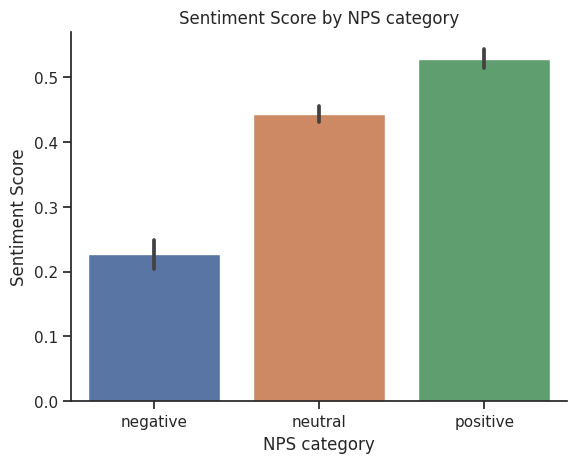

In [21]:
chart = sns.barplot(data=sample_reviews, x='NPS', y='compound')
chart.set(xlabel="NPS category",
       ylabel='Sentiment Score',
       title='Sentiment Score by NPS category')

When looking at the score breakdown for each emotion separetly, we can see that the emotions scores matches the expected trend based on the 
review's rating.
Meaning that the positive score goes up as the rating is more positive
and vice versa for the negative score.

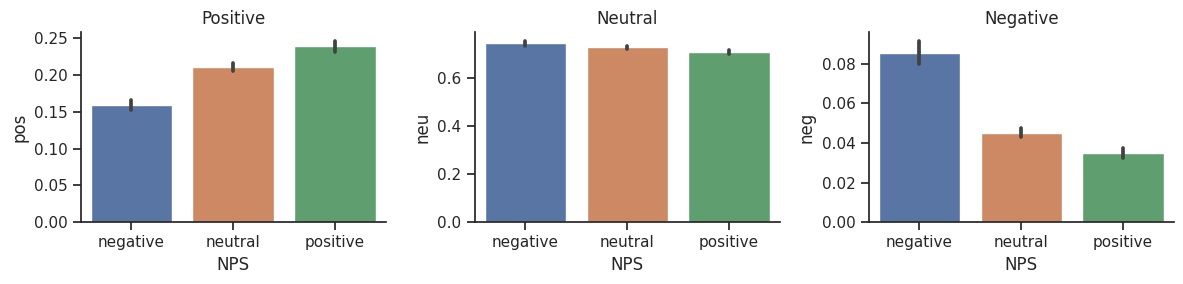

In [22]:

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=sample_reviews, x='NPS', y='pos', ax=axs[0])
sns.barplot(data=sample_reviews, x='NPS', y='neu', ax=axs[1])
sns.barplot(data=sample_reviews, x='NPS', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In conclusion, 
while the sentiment analysis does provide some insights into the directionality of the rating, it is far from being a tool that single handedly can explain the rating.
The compound score only has a corrolation of ~24% with the rating

In [23]:
sample_reviews[['rating', 'compound']].corr()

,rating,compound
rating,1.000000,0.250275
compound,0.250275,1.000000


## Bonus section - word cloud
we take all the words from our sample of comments to create a word cloud.
For improved results, we remove stop words (like: "is", "a", "and"), and punctuations from the text.
This processing is done using spacy.

In [24]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [25]:
def spacy_analysis(comment):
    main_sentence = []
    for word in nlp(comment):
        if (not word.is_stop) and (not word.is_punct):
            main_sentence.append(word.lemma_.strip().lower())
    return ' '.join(main_sentence)

In [26]:
wordcount_sample = sample_reviews.sample(1000)
wordcount_sample['nlp_text'] = wordcount_sample['comment'].apply(lambda x: spacy_analysis(x))

We can see that the main words are related to the game, 
such as "game", "theme" and "card"
but also positive descriptions such as "good", "great", "fun"
overall, it makes a board game enthusiastic like me happy seeing these results

(-0.5, 399.5, 199.5, -0.5)

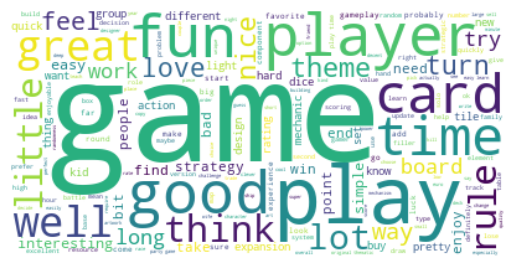

In [27]:
from wordcloud import WordCloud
text = ' '.join(wordcount_sample['nlp_text'].tolist())
wc = WordCloud(background_color="white", repeat=True)
wc.generate(text)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")